2007-01-04 00:00:00 strategy [INFO] BUY at $23.55
2007-01-11 00:00:00 strategy [INFO] SELL at $22.37 with a stop order
2007-01-12 00:00:00 strategy [INFO] BUY at $22.65
2007-01-24 00:00:00 strategy [INFO] SELL at $23.55 with a market order
2007-01-25 00:00:00 strategy [INFO] BUY at $23.59
2007-02-06 00:00:00 strategy [INFO] SELL at $24.24 with a market order
2007-02-07 00:00:00 strategy [INFO] BUY at $23.95
2007-02-21 00:00:00 strategy [INFO] SELL at $24.27 with a market order
2007-02-22 00:00:00 strategy [INFO] BUY at $24.85
2007-03-06 00:00:00 strategy [INFO] SELL at $24.66 with a market order
2007-03-07 00:00:00 strategy [INFO] BUY at $24.77
2007-03-20 00:00:00 strategy [INFO] SELL at $24.30 with a market order
2007-03-21 00:00:00 strategy [INFO] BUY at $24.28
2007-04-03 00:00:00 strategy [INFO] SELL at $25.17 with a market order
2007-04-04 00:00:00 strategy [INFO] BUY at $24.99
2007-04-17 00:00:00 strategy [INFO] SELL at $25.57 with a market order
2007-04-18 00:00:00 strategy [INFO

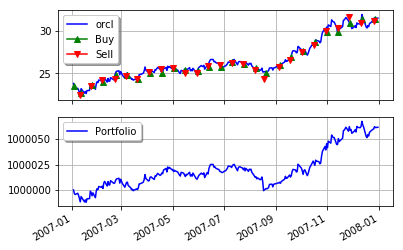

In [50]:

from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade import broker
from pyalgotrade import plotter


class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        strategy.BacktestingStrategy.__init__(self, feed)
        self.__position = None
        self.__instrument = instrument
        # We'll use adjusted close values instead of regular close values.
        #self.setUseAdjustedValues(True)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info("BUY at $%.2f" % (execInfo.getPrice()))
        self.__position.exitStop(execInfo.getPrice() * 0.95, True)

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        if position.getExitOrder().getType() == broker.Order.Type.STOP:
            order_type = "stop"
        else:
            order_type = "market"
        self.info("SELL at $%.2f with a %s order" % (execInfo.getPrice(), order_type))
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        if self.__position is None:
            self.__position = self.enterLong(self.__instrument, 10, True)
        elif self.__position.getAge().days > 10:
            # Cancel the exit stop order after 10 days, and we'll close the position with a market order.
            self.__position.cancelExit()


def run_strategy(smaPeriod):
    # Load the yahoo feed from the CSV file
    feed = yahoofeed.Feed()
    feed.addBarsFromCSV("orcl", "DBC-2007-yahoofinance.csv")

    # Evaluate the strategy with the feed.
    myStrategy = MyStrategy(feed, "orcl", smaPeriod)
    plt = plotter.StrategyPlotter(myStrategy)
    myStrategy.run()
    plt.plot()

run_strategy(15)
